# Linear Regression Analysis of Artwork Data
An exercise in some more advanced data analysis against my own datasets. Data wrangling performed in the basic and advanced analysis is repeated here with minimal explanation. Some additional pre-processing of the input data was done in Excel.

Theis dataset uses data at the order line level of detail which gives better visibility into individual pieces of art.

## Import libraries

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import squarify

# Machine learning and logistic regression libraries
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge


## Import Excel file

In [184]:
# Define the URL of the dataset - in this case we are using a dataset that has been uploaded to OneDrive and shared
#file_path = 'C:\\Users\\simon\\OneDrive\\Documents\\Data Analysis\\Art\\Artwork-Items.xlsx'

# Load the dataset into a DataFrame
df = pd.read_excel('OneDrive/Documents/Data Analysis/Art/Artwork-Items-Reg.xlsx')

# Display the first few rows to ensure it loaded correctly
df.head()

,CustomerID,PortraitID,ServiceType,PortraitSubject,NumSubjects,Medium,SaleDate,Size,Unnamed: 8,Frame,CompletedDate,ActualTime,Price,PromisedBy
0,1,1,Commission,Dog,3.0,Pastel,2003-08-06,16x22,NaN,Unframed,2003-08-15,22,800.0,2003-08-22
1,2,2,Commission,House/dwelling,1.0,Pen & Ink/Watercolor,2003-08-07,11x14,NaN,NaN,2003-08-10,8,150.0,2003-08-15
2,6,8,Commission,House/dwelling,0.0,Pen & Ink / Watercolor,2003-05-01,NaN,NaN,NaN,2003-05-31,6,160.0,NaT
3,7,9,Commission,People,3.0,Graphite,2003-03-01,18x24,NaN,NaN,2003-03-31,25,1000.0,NaT
4,8,10,Commission,People,1.0,Graphite,2003-04-01,11x14,NaN,NaN,2003-04-15,16,0.0,2003-04-15


## Basic Data Cleanup
Unlike the price data used in previous analyses, the item price data is already formatted as a number and doesn't need further manipulation. There are still some rows with missing values which must be removed.

In [185]:
# Drop the rows with no order date and no sale type
df = df.dropna(subset=['SaleDate'])


In [186]:
# Filter out rows with 'Price' == 0 or 'ActualTime' == 0
df = df[(df['Price'] > 100)]
df = df[(df['ActualTime'] > 0)]

In [187]:
# Filter out any records which dont have 'ServiceType' == 'Commission' or 'ServiceType' == 'Artwork sale'
df = df[(df['ServiceType'] == 'Commission') | (df['ServiceType'] == 'Artwork sale')] 

In [188]:
df.head()

,CustomerID,PortraitID,ServiceType,PortraitSubject,NumSubjects,Medium,SaleDate,Size,Unnamed: 8,Frame,CompletedDate,ActualTime,Price,PromisedBy
0,1,1,Commission,Dog,3.0,Pastel,2003-08-06,16x22,NaN,Unframed,2003-08-15,22,800.0,2003-08-22
1,2,2,Commission,House/dwelling,1.0,Pen & Ink/Watercolor,2003-08-07,11x14,NaN,NaN,2003-08-10,8,150.0,2003-08-15
2,6,8,Commission,House/dwelling,0.0,Pen & Ink / Watercolor,2003-05-01,NaN,NaN,NaN,2003-05-31,6,160.0,NaT
3,7,9,Commission,People,3.0,Graphite,2003-03-01,18x24,NaN,NaN,2003-03-31,25,1000.0,NaT
8,12,30,Commission,Dog,2.0,Graphite,2003-09-06,Custom,NaN,NaN,2003-09-25,24,650.0,2003-10-10


## Data Transformation

The source data has been cleaned up since previous analyses and obvious outliers were corrected.

### Extract 'Year'
Since the SaleDate column is already in date/time format, the Year can be extracted directly.

In [189]:
# Create a Year column
df['Year'] = df['SaleDate'].dt.year.astype(int)

### Calculate 'Area' for each item where possible
Use data in the 'Size' column to calculate the area of each painting in square incheas.

In [190]:
# Function to calculate area from 'Size' column
def calculate_area(size):
    if pd.isna(size):
        return None  
    try:
        # Convert the value to a string
        size_str = str(size)
        # Use regular expression to find the first pair of numbers (including decimals)
        match = re.search(r'(\d+(\.\d+)?)\s*[xX*]\s*(\d+(\.\d+)?)', size_str)
        if match:
            height, width = map(float, match.groups()[::2])  # Extract only the numeric parts
            return height * width
        else:
            return None  # Handle cases where the size format is incorrect
    except ValueError:
        return None  # Handle cases where the size format is incorrect

# Apply the function to the 'Size' column and create a new 'Area' column
df['Area'] = df['Size'].apply(calculate_area)

# Display the DataFrame with the new 'Area' column
print(df['Area'].head())



0    352.0
1    154.0
2      NaN
3    432.0
8      NaN
Name: Area, dtype: float64


### Remove Records With 'Area' == null

In [191]:
# Drop any records that don't have a useable 'Area'
df = df.dropna(subset=['Area'])

### Create a Price Per Hour Feature and a Price Per Area Feature

In [192]:
df['Price_Per_Hour'] = df['Price']/df['ActualTime']
df['Price_Per_Area'] = df['Price']/df['Area']

### Separate Out Commissioned Portraits
Create a dataframe that only contains commissioned paintings.

In [193]:
df_commission = df[df['ServiceType'] == 'Commission']
df_retail = df[df['ServiceType'] == 'Artwork sale']

### Drop Commission Records with Missing Dates

In [194]:
# drop any commission records with missing dates
df_commission = df_commission.dropna(subset=['CompletedDate'])

### Filter Out Mediums Other Than Oil and Pastel
The choice of medium has an impact on pricing and time taken to complete. We're just interested in oil and pastel portraits for this analysis as they make up the bulk of the studio output.

In [195]:
# Filter out values that don't start with 'Oil' or 'Pastel'
df_commission = df_commission[df_commission['Medium'].str.match(r'^(Oil|Pastel)', na=False)]

### Remove Commission Records With no Subjects

In [196]:
df_commission = df[df['NumSubjects'] > 0]

## Linear Multi Regression

### Can We Predict the Price of a Person's Portrait?
I tend to price portraits based on a combination of my historical data and a rough assessment of how difficult I assess they will be to complete. In the absence of a 'difficulty' rating, let's examine the correlation between year, area, number of subjects and price. This requires a multi-valued linear regression.
Portraits of people are the most time-consuming and difficult to complete, so we'll focus on those for now.

In [197]:
# Filter all portraits out of the dataframe except for those of people
df_people = df_commission[(df_commission['PortraitSubject'] == 'Person') | (df_commission['PortraitSubject'] == 'People')]

Price vs year isn't a meaningful regression in the absence of any other factors. Let's calculate price per subject and see if there's any variation in that over time.

In [207]:
# Calculate price per subject. We already know that there are no zeros remaining in the NumSubjects column.
df_people.loc[:,'Price_Per_Head'] = df_people['Price']/df_people['NumSubjects']

Before we start regression, let's plot the relationships between some of the variables.


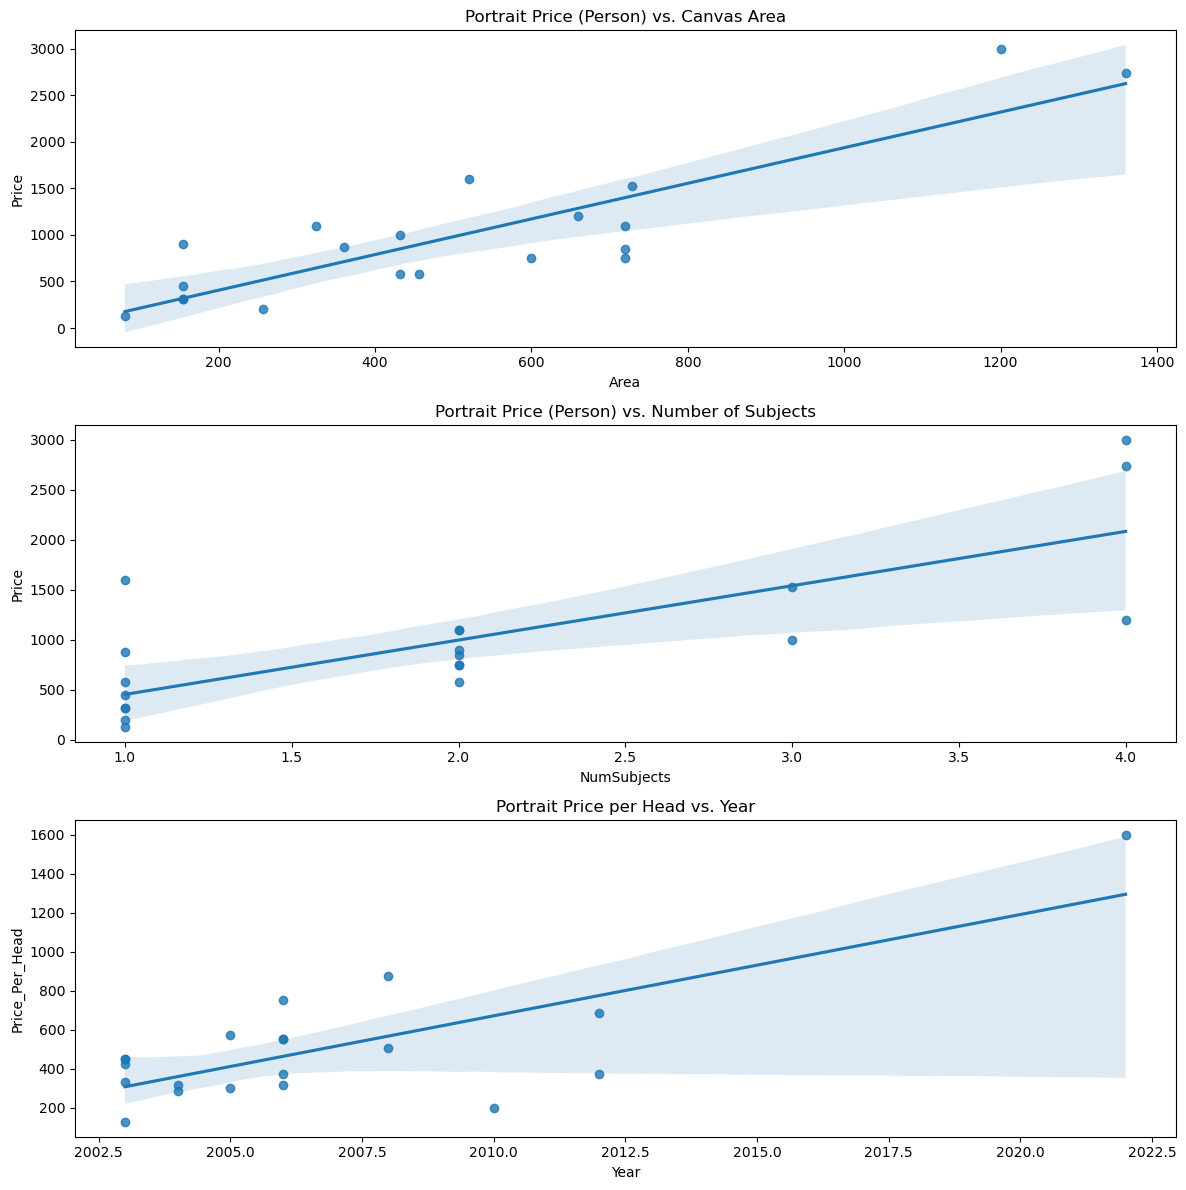

In [199]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

sns.regplot(
    x='Area',
    y='Price',
    data=df_people,
    ax=axs[0]
)
axs[0].set_title('Portrait Price (Person) vs. Canvas Area')

sns.regplot(
    x='NumSubjects',
    y='Price',
    data=df_people,
    ax=axs[1]
)
axs[1].set_title('Portrait Price (Person) vs. Number of Subjects')

sns.regplot(
    x='Year',
    y='Price_Per_Head',
    data= df_people,
    ax=axs[2]
)
axs[2].set_title('Portrait Price per Head vs. Year')

plt.tight_layout()
plt.show()

In [200]:
#Fit linear regression to predict price using list of features
x1=df_people[['Year', 'Area', 'NumSubjects']]
y1=df_people['Price']
lre_multi=LinearRegression()
lre_multi.fit(x1, y1)
print('The R2 value is: ', lre_multi.score(x1,y1))

# Get the intercept
intercept = lre_multi.intercept_
print(f"The intercept is: {intercept}")

# Get the coefficients
coefficients = lre_multi.coef_

# Display the coefficients
for feature, coef in zip(x1.columns, coefficients):
    print(f"The coefficient for {feature} is {coef}")

The R2 value is:  0.8150900489428188
The intercept is: -79272.5862260555
The coefficient for Year is 39.445110110312974
The coefficient for Area is 1.0524866390030698
The coefficient for NumSubjects is 288.76765780229414


Despite having a handful of outliers, there appears to be a reasonably strong correlation between Year, Canvas Area, Number of Subjects and Price.
Although, I might feel tempted to use this model to price out a proposal to a new customer, a quick check shows that it undervalues a portrait I would want to take on in 2025.

### Can We Predict Time to Complete?
Let's assess the correlation between year, area, number of subjects and the time to complete each portrait. This requires another multi-valued linear regression.

As with price, there's no point looking at the relationship between actual time taken and year. Let's look instead at whether the amount of time taken per subject changes over time.

In [204]:
# Calculate time per subject. We already know that there are no zeros remaining in the NumSubjects column.
df_people.loc[:,'Time_Per_Head'] = df_people['ActualTime']/df_people['NumSubjects']

Before we start regression, let's plot the relationships between some of the variables.

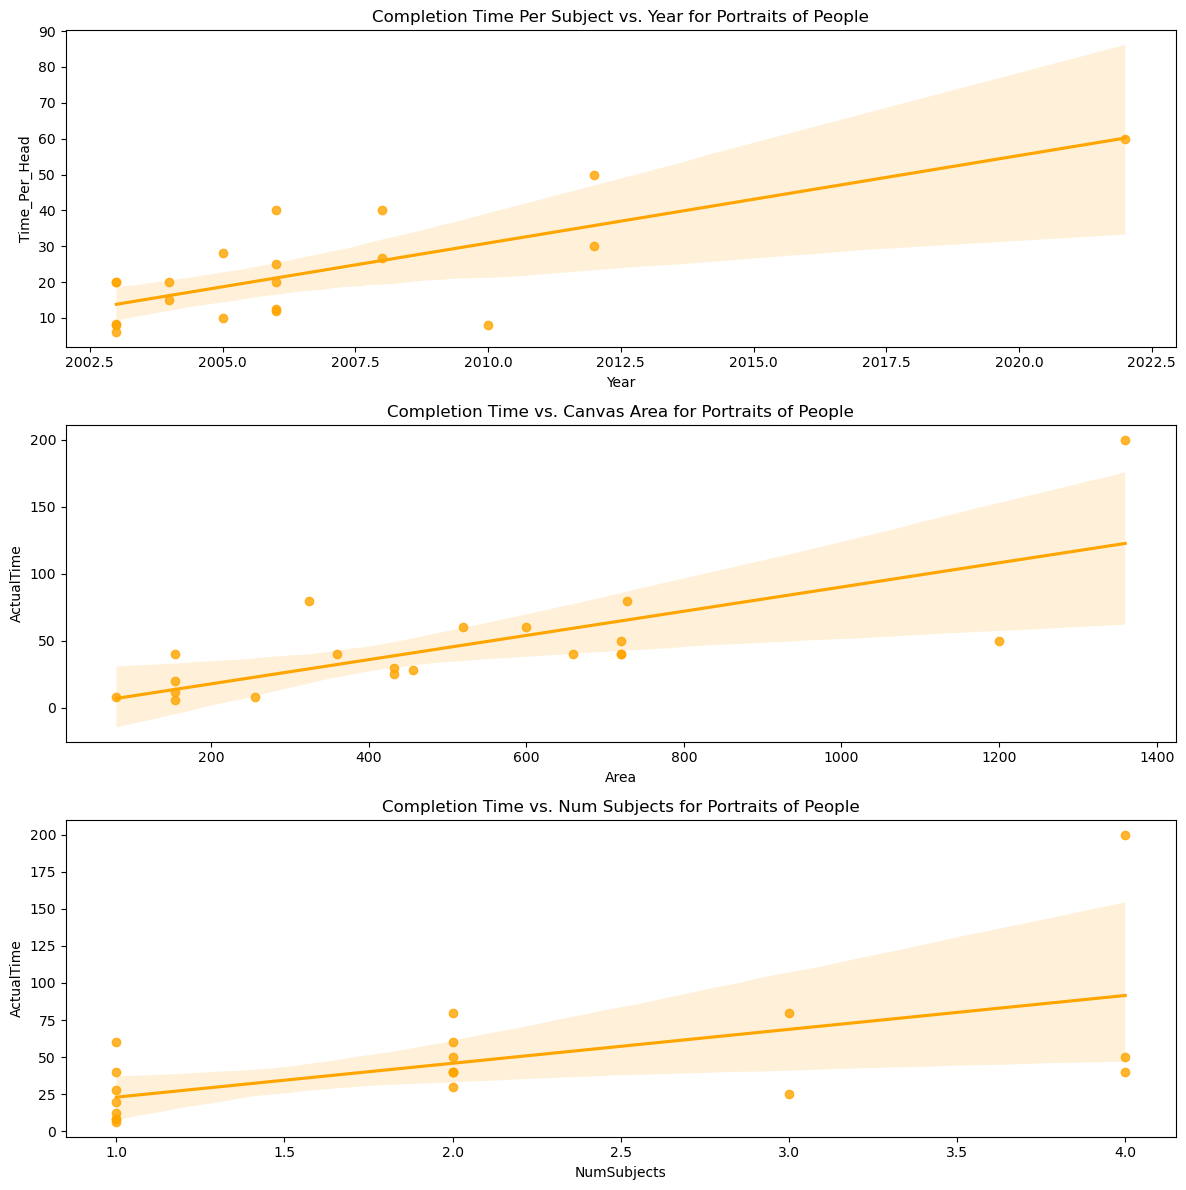

In [205]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

sns.regplot(
    x='Year',
    y='Time_Per_Head',
    data=df_people,
    color = 'orange',
    ax=axs[0]
)
axs[0].set_title('Completion Time Per Subject vs. Year for Portraits of People')

sns.regplot(
    x='Area',
    y='ActualTime',
    data=df_people,
    color = 'orange',
    ax=axs[1]
)
axs[1].set_title('Completion Time vs. Canvas Area for Portraits of People')

sns.regplot(
    x='NumSubjects',
    y='ActualTime',
    data=df_people,
    color = 'orange',
    ax=axs[2]
)
axs[2].set_title('Completion Time vs. Num Subjects for Portraits of People')

plt.tight_layout()
plt.show()

The big outlier here (200 hrs actual time), just happened to be an extremely difficult portrait to complete and took twice as long as the regression line predicts (see the last plot).

It captures an aspect of the portrait creation process that the price regression analysis misses completely—some painting projects take longer than others and it can be difficult to predict which ones those will be in advance.

In [206]:
#Fit linear regression to predict price using list of features
x2=df_people[['Year', 'Area', 'NumSubjects']]
y2=df_people['ActualTime']
lre_multi=LinearRegression()
lre_multi.fit(x2, y2)
print('The R2 value is: ', lre_multi.score(x2,y2))

# Get the intercept
intercept = lre_multi.intercept_
print(f"The intercept is: {intercept}")

# Get the coefficients
coefficients = lre_multi.coef_

# Display the coefficients
for feature, coef in zip(x2.columns, coefficients):
    print(f"The coefficient for {feature} is {coef}")

The R2 value is:  0.6059059359108159
The intercept is: -5714.259688343057
The coefficient for Year is 2.846720892057733
The coefficient for Area is 0.056146721153824325
The coefficient for NumSubjects is 9.431313897337585


We end up with a reasonably good fit for the regression but in this case, a quick check of the data for a current portrait reveals a spurious answer of negative time required. Even with the fairly wide standard deviation, the plot of actual time per subject vs. year provides a more convincing result.